In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss
import xgboost as xgb

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
oil2 = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1")
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

C:\Users\ndzad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wybieramy obserwacje dla family=AUTOMOTIVE

In [6]:
train_automotive = train.loc[(train['family']=='AUTOMOTIVE')]

In [7]:
train_automotive.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000723,2017-08-15,54,AUTOMOTIVE,8.0,0
3000756,2017-08-15,6,AUTOMOTIVE,7.0,0
3000789,2017-08-15,7,AUTOMOTIVE,5.0,0
3000822,2017-08-15,8,AUTOMOTIVE,4.0,0
3000855,2017-08-15,9,AUTOMOTIVE,15.0,0


Wyliczamy średnią sprzedaż na daną datę

In [8]:
train_automotive2= train_automotive.groupby(['date'])['sales'].mean().to_frame()

In [9]:
train_automotive2.head()

,sales
date,
2013-01-01,0.000000
2013-01-02,4.722222
2013-01-03,2.981481
2013-01-04,3.129630
2013-01-05,6.333333


Dołączamy informacje o zmiennych i robimy one-hot encoding zmiennej locale

In [10]:
train_automotive_merged = train_automotive2.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])

encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(train_automotive_merged[['locale']]).toarray())

final_train_automotive = train_automotive_merged.join(encoder_df)

final_train_automotive.drop('locale', axis=1, inplace=True)

final_train_automotive.columns = ['date', 'sales','type','local_name','description','transferred','isLocal','isNational','isRegional','isNormalDay']


In [11]:
final_train_automotive.head()

,date,sales,type,local_name,description,transferred,isLocal,isNational,isRegional,isNormalDay
0,2013-01-01,0.000000,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
1,2013-01-02,4.722222,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2,2013-01-03,2.981481,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
3,2013-01-04,3.129630,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
4,2013-01-05,6.333333,Work Day,Ecuador,Recupero puente Navidad,False,0.0,1.0,0.0,0.0


Tworzymy zmienną dayofweek

In [12]:
final_train_automotive['dayofweek'] = pd.DatetimeIndex(final_train_automotive['date']).dayofweek + 1

In [13]:
final_train_automotive.head()

,date,sales,type,local_name,description,transferred,isLocal,isNational,isRegional,isNormalDay,dayofweek
0,2013-01-01,0.000000,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
1,2013-01-02,4.722222,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,3
2,2013-01-03,2.981481,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,4
3,2013-01-04,3.129630,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,5
4,2013-01-05,6.333333,Work Day,Ecuador,Recupero puente Navidad,False,0.0,1.0,0.0,0.0,6


Dodajemy oil jako zmienną objaśniającą.

In [14]:
train_automotive_oil = final_train_automotive.merge(oil2,how="left",left_on=['date'],right_on=['date'])

In [15]:
train_automotive_oil.head()

,date,sales,type,local_name,description,transferred,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
0,2013-01-01,0.000000,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2,NaN
1,2013-01-02,4.722222,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,3,93.14
2,2013-01-03,2.981481,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,4,92.97
3,2013-01-04,3.129630,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,5,93.12
4,2013-01-05,6.333333,Work Day,Ecuador,Recupero puente Navidad,False,0.0,1.0,0.0,0.0,6,NaN


Interpolacja

In [16]:
train_automotive_oil.interpolate(method ='linear', limit_direction ='backward', inplace=True)

In [17]:
train_automotive_oil.tail(10)

,date,sales,type,local_name,description,transferred,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
1704,2017-08-06,10.796296,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,7,49.436667
1705,2017-08-07,6.574074,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1,49.370000
1706,2017-08-08,6.055556,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,2,49.070000
1707,2017-08-09,5.814815,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,3,49.590000
1708,2017-08-10,5.796296,Holiday,Ecuador,Primer Grito de Independencia,True,0.0,1.0,0.0,0.0,4,48.540000
1709,2017-08-11,8.166667,Transfer,Ecuador,Traslado Primer Grito de Independencia,False,0.0,1.0,0.0,0.0,5,48.810000
1710,2017-08-12,7.462963,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,6,48.403333
1711,2017-08-13,8.907407,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,7,47.996667
1712,2017-08-14,5.407407,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1,47.590000
1713,2017-08-15,6.240741,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0,2,47.570000


Dzielimy próbkę train na treningową i testową.

In [18]:
train2 = train_automotive_oil.loc[(train_automotive_oil['date']<'2016-06-01')]
test2 = train_automotive_oil.loc[(train_automotive_oil['date']>='2016-06-01')].reset_index(drop=True)

In [19]:
test2.head()

,date,sales,type,local_name,description,transferred,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
0,2016-06-01,6.425926,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,3,49.07
1,2016-06-02,5.740741,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,4,49.14
2,2016-06-03,5.888889,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,5,48.69
3,2016-06-04,9.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,6,49.03
4,2016-06-05,11.185185,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,7,49.37


In [20]:
train2_date = train2.copy()
train2.drop(["description","date","type","local_name","transferred"],axis=1,inplace=True)
test2.drop(["description","date","type","local_name","transferred"],axis=1,inplace=True)

C:\Users\ndzad\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Tworzymy model liniowy

In [36]:
X = train2.drop(['sales'],axis=1)
Y = train2['sales']

In [22]:
model = sm.OLS(Y,X).fit()

In [23]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     239.3
Date:                Sun, 15 May 2022   Prob (F-statistic):          1.08e-179
Time:                        16:49:21   Log-Likelihood:                -2206.9
No. Observations:                1264   AIC:                             4426.
Df Residuals:                    1258   BIC:                             4457.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
isLocal         6.2705      0.206     30.386      

In [24]:
test2.head()

,sales,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
0,6.425926,0.0,0.0,0.0,1.0,3,49.07
1,5.740741,0.0,0.0,0.0,1.0,4,49.14
2,5.888889,0.0,0.0,0.0,1.0,5,48.69
3,9.000000,0.0,0.0,0.0,1.0,6,49.03
4,11.185185,0.0,0.0,0.0,1.0,7,49.37


In [25]:
train2.head()

,sales,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
0,0.000000,0.0,1.0,0.0,0.0,2,93.140000
1,4.722222,0.0,0.0,0.0,1.0,3,93.140000
2,2.981481,0.0,0.0,0.0,1.0,4,92.970000
3,3.129630,0.0,0.0,0.0,1.0,5,93.120000
4,6.333333,0.0,1.0,0.0,0.0,6,93.146667


In [26]:
test2_drop = test2.drop(['sales'],axis=1)
Y_test = test2['sales']

In [27]:
test2.head()

,sales,isLocal,isNational,isRegional,isNormalDay,dayofweek,dcoilwtico
0,6.425926,0.0,0.0,0.0,1.0,3,49.07
1,5.740741,0.0,0.0,0.0,1.0,4,49.14
2,5.888889,0.0,0.0,0.0,1.0,5,48.69
3,9.000000,0.0,0.0,0.0,1.0,6,49.03
4,11.185185,0.0,0.0,0.0,1.0,7,49.37


In [28]:
Y_pred = model.predict(test2_drop)

Policzmy MSE.

In [29]:
mean_squared_error(Y_test,Y_pred)

2.7756961974770498

In [37]:
model2 = xgb.XGBRFRegressor().fit(X,Y)

In [40]:
Y2_pred = model2.predict(test2_drop)

In [41]:
mean_squared_error(Y_test,Y2_pred)

1.964758429544069

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

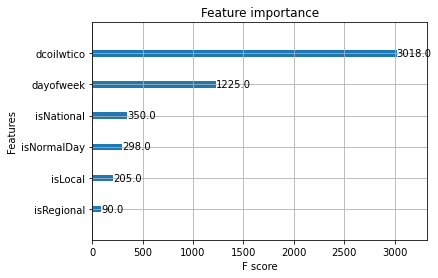

In [47]:
xgb.plot_importance(model2)

In [49]:
train_automotive = train.loc[(train['family']=='AUTOMOTIVE')]

In [51]:
train_automotive_1 = train_automotive.loc[(train_automotive['store_nbr']==1)]

In [113]:
train_automotive_1_oil = train_automotive_1.merge(oil2,how="left",left_on=['date'],right_on=['date'])

In [114]:
train_automotive_merged = train_automotive_1_oil.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(train_automotive_merged[['locale']]).toarray())


final_train_automotive = train_automotive_merged.join(encoder_df)

final_train_automotive.drop('locale', axis=1, inplace=True)

In [115]:
final_train_automotive

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale_name,description,transferred,0,1,2,3
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
1,2013-01-01,1,BABY CARE,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
2,2013-01-01,1,BEAUTY,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
4,2013-01-01,1,BOOKS,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56557,2017-08-15,1,POULTRY,234.892000,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0
56558,2017-08-15,1,PREPARED FOODS,42.822998,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0
56559,2017-08-15,1,PRODUCE,2240.230000,7,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0
56560,2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0.000000,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0


In [116]:
final_train_automotive.rename(columns = {0:'locale_0',1:'locale_1',2:'locale_2',3:'locale_3'}, inplace = True)

In [117]:
final_train_automotive['dayofweek'] = pd.DatetimeIndex(final_train_automotive['date']).dayofweek + 1

In [118]:
final_train_automotive

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale_name,description,transferred,locale_0,locale_1,locale_2,locale_3,dayofweek
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
1,2013-01-01,1,BABY CARE,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
2,2013-01-01,1,BEAUTY,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
3,2013-01-01,1,BEVERAGES,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
4,2013-01-01,1,BOOKS,0.000000,0,NaN,Holiday,Ecuador,Primer dia del ano,False,0.0,1.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56557,2017-08-15,1,POULTRY,234.892000,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0,2
56558,2017-08-15,1,PREPARED FOODS,42.822998,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0,2
56559,2017-08-15,1,PRODUCE,2240.230000,7,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0,2
56560,2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0.000000,0,47.57,Holiday,Riobamba,Fundacion de Riobamba,False,1.0,0.0,0.0,0.0,2


In [119]:
train2 = final_train_automotive.loc[(final_train_automotive['date']<'2016-06-01')].interpolate(method ='linear', limit_direction ='backward').drop(['store_nbr','family','date','description','type','locale_name','transferred'],axis=1)
test2 = final_train_automotive.loc[(final_train_automotive['date']>='2016-06-01')].reset_index(drop=True).interpolate(method ='linear', limit_direction ='backward').drop(['store_nbr','family','date','description','type','locale_name','transferred'],axis=1)

In [120]:
test2

,sales,onpromotion,dcoilwtico,locale_0,locale_1,locale_2,locale_3,dayofweek
0,3.000000,0,49.07,0.0,0.0,0.0,1.0,3
1,0.000000,0,49.07,0.0,0.0,0.0,1.0,3
2,4.000000,0,49.07,0.0,0.0,0.0,1.0,3
3,2199.000000,37,49.07,0.0,0.0,0.0,1.0,3
4,0.000000,0,49.07,0.0,0.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...
14845,234.892000,0,47.57,1.0,0.0,0.0,0.0,2
14846,42.822998,0,47.57,1.0,0.0,0.0,0.0,2
14847,2240.230000,7,47.57,1.0,0.0,0.0,0.0,2
14848,0.000000,0,47.57,1.0,0.0,0.0,0.0,2


In [121]:
X = train2.drop(['sales'],axis=1)
Y = train2['sales']

In [122]:
model2 = xgb.XGBRFRegressor().fit(X,Y)

In [123]:
test2_drop = test2.drop(['sales'],axis=1)
Y_test = test2['sales']

In [124]:
Y2_pred = model2.predict(test2_drop)

In [125]:
mean_squared_error(Y_test,Y2_pred)

406634.11704842834

Dla jednego sklepu

In [127]:
train_1 = train.loc[(train['store_nbr']==1)]

In [128]:
train_1= train_1.groupby(['date'])['sales'].mean().to_frame()

In [129]:
train_1_merged = train_1.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])

encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(train_1_merged[['locale']]).toarray())

final_train_1 = train_1_merged.join(encoder_df)

final_train_1.drop('locale', axis=1, inplace=True)

final_train_1.columns = ['date', 'sales','type','local_name','description','transferred','isLocal','isNational','isRegional','isNormalDay']

final_train_1['dayofweek'] = pd.DatetimeIndex(final_train_1['date']).dayofweek + 1

In [130]:
train_1_oil = final_train_1.merge(oil2,how="left",left_on=['date'],right_on=['date'])

In [131]:
train2 = train_1_oil.loc[(train_1_oil['date']<'2016-06-01')]
test2 = train_1_oil.loc[(train_1_oil['date']>='2016-06-01')].reset_index(drop=True)

In [132]:
train2_date = train2.copy()
train2.drop(["description","date","type","local_name","transferred"],axis=1,inplace=True)
test2.drop(["description","date","type","local_name","transferred"],axis=1,inplace=True)

C:\Users\ndzad\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [135]:
X = train2.drop(['sales'],axis=1)
Y = train2['sales']
test2_drop = test2.drop(['sales'],axis=1)
Y_test = test2['sales']

In [136]:
model_sklep1 = xgb.XGBRFRegressor().fit(X,Y)

In [137]:
Y2_pred = model_sklep1.predict(test2_drop)

In [138]:
mean_squared_error(Y_test,Y2_pred)

8540.351366337281